# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

##  Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="app/Tennis.app")

Mono path[0] = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.10000000149011612


When finished, you can close the environment.

In [6]:
env.close()

## 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## DDPG

In [5]:
import time
from collections import deque
from datetime import datetime
import torch
import numpy as np
from unityagents import UnityEnvironment

PASSING_SCORE = 0.5

def ini():
    env = UnityEnvironment(file_name="app/Tennis.app")

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

    return env, brain_name, brain, num_agents, action_size, states, state_size


def ddpg(agent, n_episodes=3500, max_t=1000, print_every=100, verbose=True, save_models=True,
         returnFullscores=True, stopTrainingAfterGoal=True):
    scores = []
    haventWon = True
    for i_episode in range(1, n_episodes + 1):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for _ in range(max_t):
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]  # send all actions to tne environment

            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished

            agent.step(states, actions, rewards, next_states, dones)

            states = next_states  # roll over states to next time step
            score += rewards  # update the score (for each agent)

            if np.any(dones): break

        score = np.max(score)
        scores.append(score)
        windowavg = np.mean(scores[-min(100, len(scores)):])
        if verbose: print('\rEpisode {}\tEpisode Score: {:.3f}\tAverage Score: {:.3f}'.format(i_episode,
                                                                                              scores[-1],
                                                                                              windowavg), end="")
        if i_episode % print_every == 0:
            if verbose: print()

        if windowavg > PASSING_SCORE and haventWon:
            haventWon = False
            if verbose:  print(f'\nProblem solved after {i_episode} with {windowavg} from past 100 episodes.')
            if stopTrainingAfterGoal: break
            if save_models:
                np.save(f'saved_scores/scores_ddpg_{agent.PER}-PER_{i_episode}.npy', scores)
                torch.save(agent.actor_local.state_dict(), f'saved_models/checkpoint_actor_ddpg_{agent.PER}-PER.pth')
                torch.save(agent.critic_local.state_dict(), f'saved_models/checkpoint_critic_ddpg_{agent.PER}-PER.pth')

    if save_models:
        torch.save(agent.actor_local.state_dict(), f'saved_models/finished_actor_ddpg_{agent.PER}-PER.pth')
        torch.save(agent.critic_local.state_dict(), f'saved_models/finished_critic_ddpg_{agent.PER}-PER.pth')
        np.save(f'saved_scores/scores_ddpg_{agent.PER}-PER.npy', scores)

    return scores if returnFullscores else i_episode

def plotScores(scores, title='', color='g', window=100):
    import matplotlib.pyplot as plt
    import pandas as pd

    rolling = pd.Series(scores).rolling(window).mean().values
    indx_rolling = np.where(rolling >  PASSING_SCORE)[0]
    indx = np.where(np.array(scores) > PASSING_SCORE)[0]

    if len(indx) < 1: indx = "didn't reach"
    else: indx = indx[0]

    if len(indx_rolling) < 1: indx_rolling = "didn't reach"
    else: indx_rolling = indx_rolling[0]

    print(title)
    print(f'First time reaches target of {PASSING_SCORE}: {indx};')
    print(f'First time reaches target of {PASSING_SCORE} with average of window {window}: {indx_rolling}')
    print(f'Maximum score: {max(scores):.3f}; Latest avg with window of {window}: {rolling[-1]:.3f} ; Entire Avg scores {np.mean(scores):.3f}')
    # plot the scores
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121)
    plt.plot(np.arange(len(scores)), scores, color=color)
    plt.title(title)
    plt.ylabel('Score' + title)
    plt.xlabel('Episode #')

    secondcolor = 'r' if color != 'r' else 'b'
    ax = fig.add_subplot(122)
    plt.plot(np.arange(len(scores)), rolling, color=secondcolor)
    plt.title('Rolling Avg ' + title)
    plt.ylabel('Score' + title)
    plt.xlabel('Episode #')
    plt.show()
    

### Without Prioritized Experience Learning (PER)

In [9]:
from utils.agent_tennis_ddpg import AgentDDPG

env, brain_name, brain, num_agents, action_size, states, state_size = ini()
agent_ddpg = AgentDDPG(state_size=state_size, action_size=action_size, random_seed=32,
                       num_agents=num_agents, prioritized_experience_learning=False)
start = time.time()
scores_ddpg = ddpg(agent_ddpg, stopTrainingAfterGoal=False)
print('lasted:', time.time()-start,'seg')

Mono path[0] = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/MonoBleedingEdge/etc'
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.         

DDPG Tennis without PER
First time reaches target of 0.5: 889;
First time reaches target of 0.5 with average of window 100: 1013
Maximum score: 2.700; Latest avg with window of 100: 0.375 ; Entire Avg scores 0.297


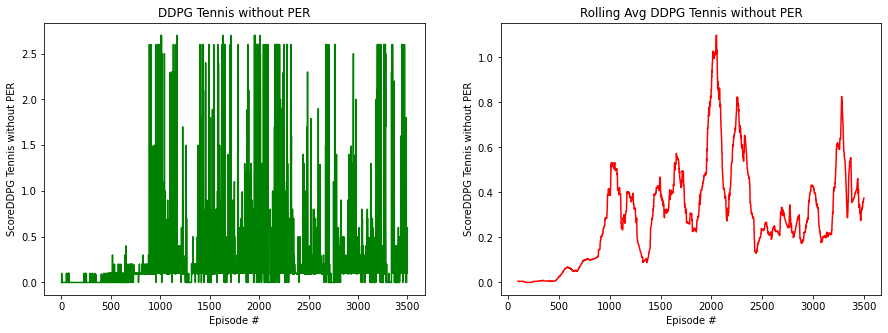

In [26]:
plotScores(scores_ddpg, title='DDPG Tennis without PER')

### With PER

In [10]:
from utils.agent_tennis_ddpg import AgentDDPG

env, brain_name, brain, num_agents, action_size, states, state_size = ini()
agent_ddpg_per = AgentDDPG(state_size=state_size, action_size=action_size, random_seed=32,
                       num_agents=num_agents, prioritized_experience_learning=False)

start = time.time()
scores_ddpg_per = ddpg(agent_ddpg_per, stopTrainingAfterGoal=False)
print('lasted:', time.time()-start,'seg')


Mono path[0] = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/MonoBleedingEdge/etc'
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.        

DDPG Tennis with PER
First time reaches target of 0.5: 520;
First time reaches target of 0.5 with average of window 100: 650
Maximum score: 2.700; Latest avg with window of 100: 0.637 ; Entire Avg scores 0.352


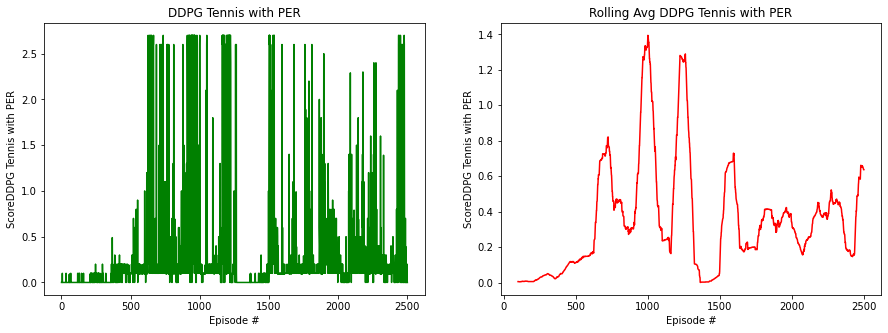

In [8]:
plotScores(scores_ddpg_per, title='DDPG Tennis with PER')

## PPO

In [1]:
import time
from collections import deque
from datetime import datetime
import torch
import numpy as np
from unityagents import UnityEnvironment

PASSING_SCORE = 0.5

def ini():
    env = UnityEnvironment(file_name="app/Tennis.app")

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
    print('The state for the first agent looks like:', states[0])

    return env, brain_name, brain, num_agents, action_size, states, state_size

def train_ppo(env, brain_name, num_agents, state_dim, action_dim, n_episodes=30000):
    has_continuous_action_space = True
    max_ep_len = 400  # max timesteps in one episode

    update_timestep = max_ep_len * 4  # update policy every n timesteps
    K_epochs = 40  # update policy for K epochs
    eps_clip = 0.2  # clip parameter for PPO
    gamma = 0.99  # discount factor

    lr_actor = 0.0003  # learning rate for actor network
    lr_critic = 0.001  # learning rate for critic network
    random_seed = 32  # set random seed if required (0 = no random seed)

    action_std = 0.6  # starting std for action distribution (Multivariate Normal)
    action_std_decay_rate = 0.05  # linearly decay action_std (action_std = action_std - action_std_decay_rate)
    min_action_std = 0.1  # minimum action_std (stop decay after action_std <= min_action_std)
    action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)

    print_every = 100

    print("--------------------------------------------------------------------------------------------")
    print("max timesteps per episode : ", max_ep_len)
    print("--------------------------------------------------------------------------------------------")
    print("state space dimension : ", state_dim)
    print("action space dimension : ", action_dim)
    print("--------------------------------------------------------------------------------------------")

    if has_continuous_action_space:
        print("Initializing a continuous action space policy")
        print("--------------------------------------------------------------------------------------------")
        print("starting std of action distribution : ", action_std)
        print("decay rate of std of action distribution : ", action_std_decay_rate)
        print("minimum std of action distribution : ", min_action_std)
        print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")
    else:
        print("Initializing a discrete action space policy")

    print("--------------------------------------------------------------------------------------------")

    print("PPO update frequency : " + str(update_timestep) + " timesteps")
    print("PPO K epochs : ", K_epochs)
    print("PPO epsilon clip : ", eps_clip)
    print("discount factor (gamma) : ", gamma)

    print("--------------------------------------------------------------------------------------------")

    print("optimizer learning rate actor : ", lr_actor)
    print("optimizer learning rate critic : ", lr_critic)

    if random_seed:
        print("--------------------------------------------------------------------------------------------")
        print("setting random seed to ", random_seed)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

    print("============================================================================================")

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space)

    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    print("============================================================================================")

    # printing and logging variables
    scores = []

    time_step = 0
    haventWon = True

    # training loop
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset()[brain_name]
        state = env_info.vector_observations
        current_ep_reward = np.zeros(num_agents)

        for t in range(1, max_ep_len + 1):

            # select action with policy
            action = ppo_agent.select_action(state)

            env_info = env.step(action)[brain_name]
            state = env_info.vector_observations
            reward = env_info.rewards
            reward = np.where(np.isnan(reward), 0, reward)
            done = np.array([1 if t else 0 for t in env_info.local_done])

            # saving reward and is_terminals
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)

            time_step += 1
            current_ep_reward += reward

            # update PPO agent
            if time_step % update_timestep == 0:
                ppo_agent.update()

            # if continuous action space; then decay action std of ouput action distribution
            if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

            # break; if the episode is over
            if np.any(done):
                break

        score = max(current_ep_reward)
        scores.append(score)
        windowavg = np.mean(scores[-min(100, len(scores)):])

        print('\rEpisode {}\tEpisode Score: {:.3f}\tAverage Score: {:.3f}'.format(i_episode, scores[-1], windowavg),
              end="")

        if i_episode % print_every == 0: print()

        if windowavg > 0.5 and haventWon:
            haventWon = False
            print(f'\nProblem solved after {i_episode} with {windowavg} from past 100 episodes.')
            np.save(f'saved_scores/scores_ppo_2_{i_episode}.npy', scores)
            ppo_agent.save(f'saved_models/checkpoint_ppo.pth')

    env.close()
    np.save('scores_ppo.npy', scores)
    ppo_agent.save(f'saved_models/finished_ppo.pth')
    # print total training time
    print("============================================================================================")
    end_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)
    print("Finished training at (GMT) : ", end_time)
    print("Total training time  : ", end_time - start_time)
    print("============================================================================================")

    return scores

In [11]:
from utils.agent_tennis_ppo import PPO

env, brain_name, brain, num_agents, action_size, states, state_size = ini()

start = time.time()
scores_ppo = train_ppo(env, brain_name, num_agents, state_size, action_size, n_episodes=18000)
print('lasted:', time.time()-start,'seg')


Mono path[0] = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/joao/Documents/Udacity/RL/RL-TennisPlayers/app/Tennis.app/Contents/MonoBleedingEdge/etc'
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.        

In [ ]:
env.close

PPO Tennis
First time reaches target of 0.5: 3775;
First time reaches target of 0.5 with average of window 100: 15321
Maximum score: 1.100; Latest avg with window of 100: 0.643 ; Entire Avg scores 0.207


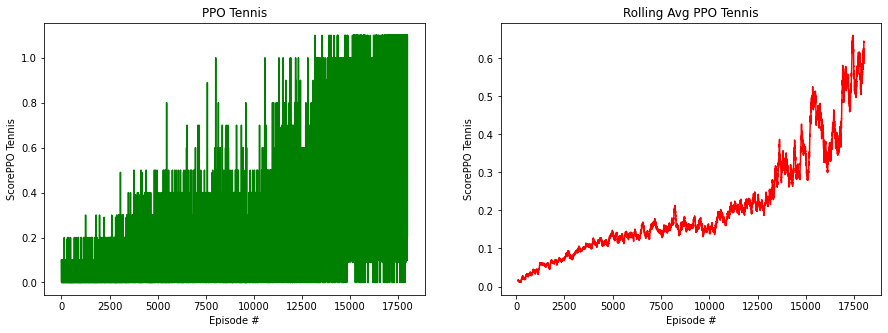

In [13]:
plotScores(scores_ppo, title='PPO Tennis')

# Plot All

In [14]:
import numpy as np
import os
import pandas as pd

In [19]:
files = os.listdir('saved_scores')
files = [f for f in os.listdir('saved_scores') if 'ppo' not in f]
files

['.DS_Store',
 'scores_ddpg_True-PER_2.npy',
 'scores_ddpg_True-PER_1.npy',
 'scores_ddpg_False-PER_2.npy',
 'scores_ddpg_False-PER_1.npy',
 'timings.txt']

In [20]:
all_saved  = [np.load(open('saved_scores/' + f,'rb')) for f in files if f.endswith('npy')]
names_saved = [f for f in files if f.endswith('npy')]

all_rolled = [pd.Series(n).rolling(100).mean().values for n in all_saved]

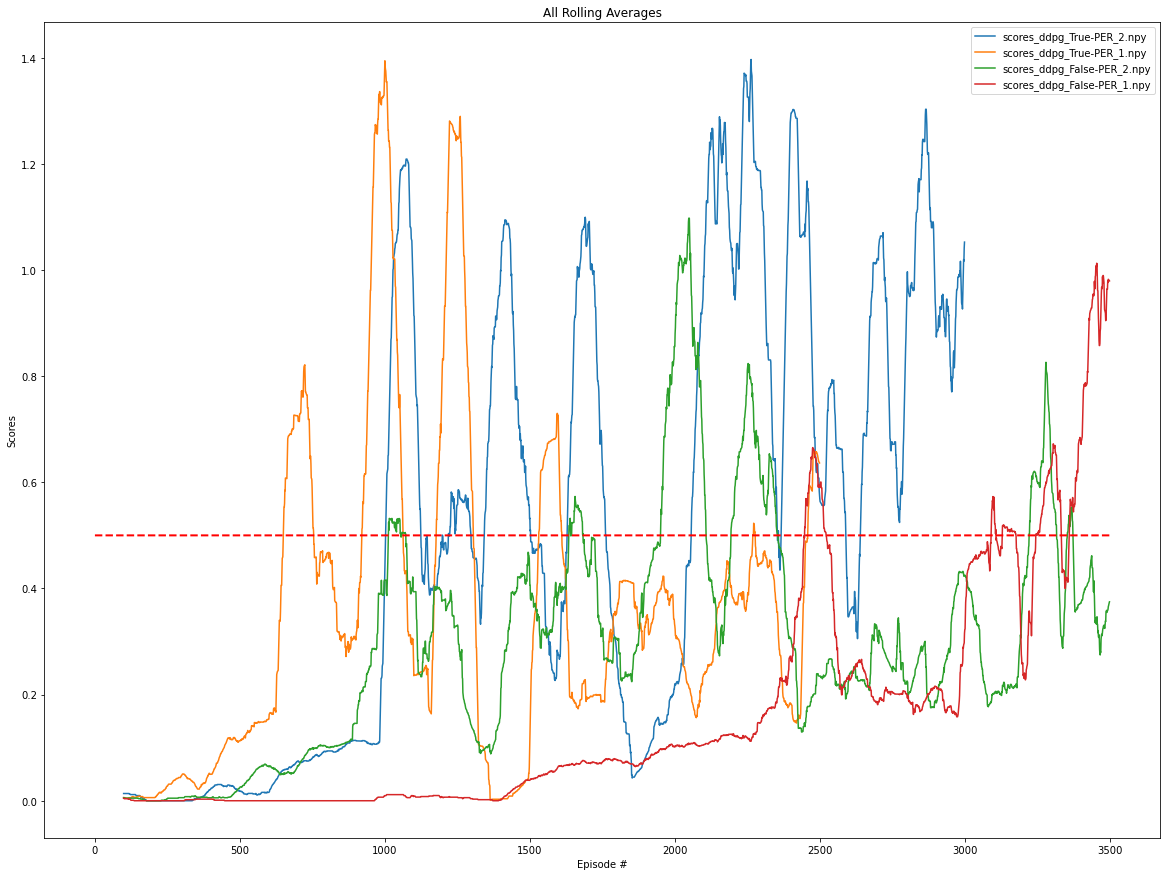

In [21]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
for lab, scor in zip(names_saved, all_rolled):
    plt.plot(np.arange(len(scor)), scor, label=lab)

max_len = max(map(len, all_rolled))
y = np.full(shape=max_len, fill_value=0.5)
x = np.arange(max_len)
# adding passing score line
plt.plot(x, y, color='red', linestyle='dashed',linewidth=2)
plt.title("All Rolling Averages")
ax.legend()
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.savefig('Images/run_allrolling.png')
plt.show()

In [22]:
files = os.listdir('saved_scores')
all_saved  = [np.load(open('saved_scores/' + f,'rb')) for f in files if f.endswith('npy')]
names_saved = [f for f in files if f.endswith('npy')]

all_rolled = [pd.Series(n).rolling(100).mean().values for n in all_saved]

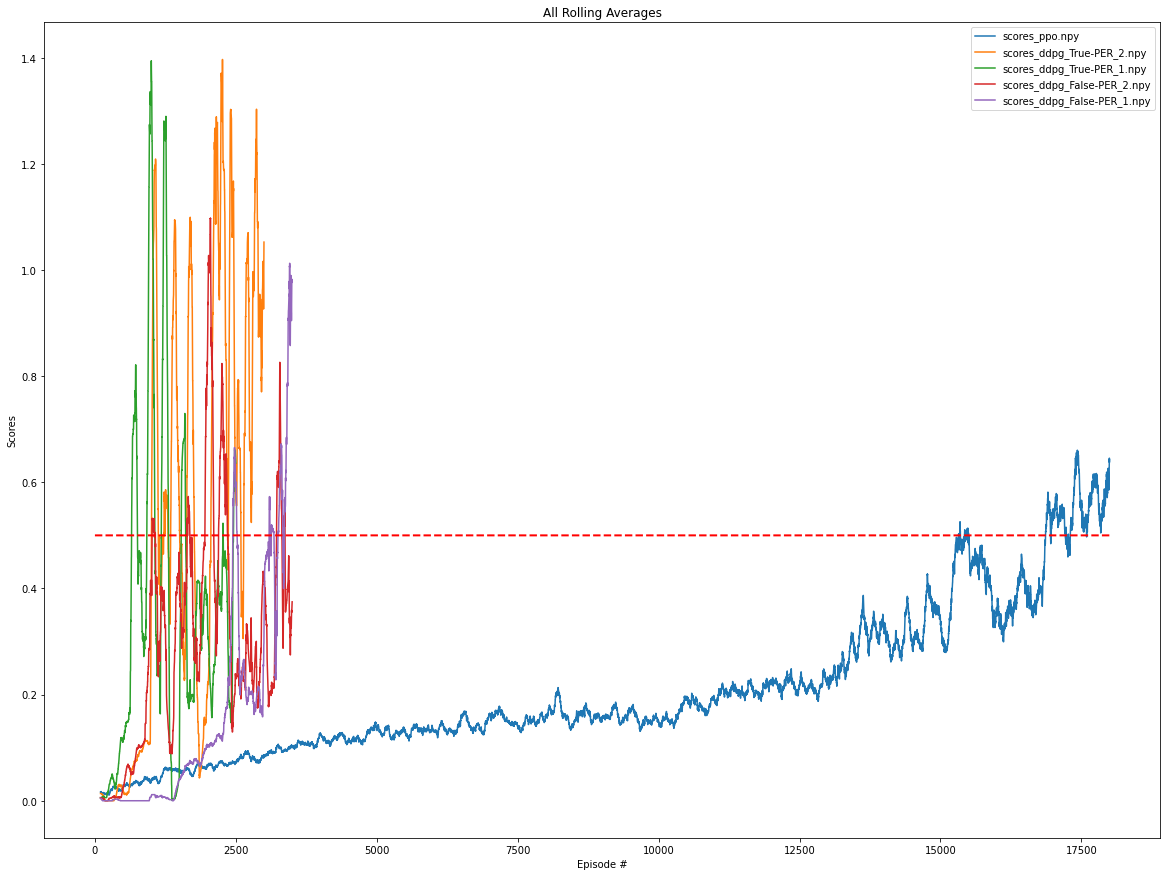

In [23]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
for lab, scor in zip(names_saved, all_rolled):
    plt.plot(np.arange(len(scor)), scor, label=lab)

max_len = max(map(len, all_rolled))
y = np.full(shape=max_len, fill_value=0.5)
x = np.arange(max_len)
# adding passing score line
plt.plot(x, y, color='red', linestyle='dashed',linewidth=2)
plt.title("All Rolling Averages")
ax.legend()
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.savefig('Images/run_allrolling.png')
plt.show()